In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
pip install tensorflow-gpu

     |████████████████████████████████| 497.5 MB 21 kB/s              
     |████████████████████████████████| 1.4 MB 50.3 MB/s            
     |████████████████████████████████| 14.5 MB 31.9 MB/s            
     |████████████████████████████████| 5.8 MB 25.9 MB/s            
     |████████████████████████████████| 462 kB 64.1 MB/s            
     |████████████████████████████████| 2.1 MB 27.5 MB/s            
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2

In [3]:
Image_Size= 256
Batch_Size = 32
Channels=3
Epochs=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/chest-xray-pneumonia/chest_xray/train",
    shuffle=True,
    image_size = (Image_Size,Image_Size),
    batch_size=Batch_Size

)

Found 5216 files belonging to 2 classes.


2022-02-20 09:06:41.830176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 09:06:41.936092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 09:06:41.937092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 09:06:41.939813: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
class_names = dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

2022-02-20 09:06:44.970225: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(32, 256, 256, 3)
[1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1]


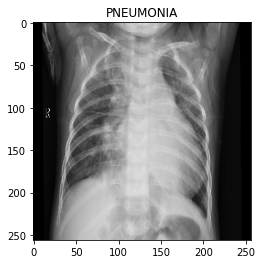

In [7]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

In [8]:
def splitting_dataset_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size=len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size=int(train_split * ds_size)
    val_size= int(val_split * ds_size)
    
    train_ds= ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds=splitting_dataset_tf(dataset)

In [10]:
len(train_ds)

130

In [11]:
len(val_ds)

16

In [12]:
len(test_ds)

17

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size,Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
input_shape = (Batch_Size,Image_Size, Image_Size,Channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation= 'softmax'),
    
])

model.build(input_shape=input_shape)

In [17]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    epochs=Epochs,
    batch_size=Batch_Size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-02-20 09:07:05.893670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 34 of 10000
2022-02-20 09:07:15.811144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 78 of 10000
2022-02-20 09:07:25.854988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 119 of 10000
2022-02-20 09:07:35.006456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-02-20 09:07:35.006542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-02-20 09:07:35.006566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2 of 1000
2022-02-20 09:07:35.006579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 3 of 1000
20

129/130 [============================>.] - ETA: 0s - loss: 0.5721 - accuracy: 0.7483WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f24a0366560> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
130/130 [==============================] - 54s 57ms/step - loss: 0.5713 - accuracy: 0.7488 - val_loss: 0.4981 - val_accuracy: 0.7935
Epoch 2/50
130/130 [==============================] - 6s 48ms/step - loss: 0.4144 - accuracy: 0.8329 - val_loss: 0.2542 - val_accuracy: 0.8935
Epoch 3/50
130/130 [==============================] - 6s 48ms/step - loss: 0.2827 - accuracy: 0.8846 - val_loss: 0.2270 - val_accuracy: 0.9173
Epoch 4/50
130/

In [19]:
scores = model.evaluate(test_ds)

130/130 [==============================] - 2s 13ms/step - loss: 0.0978 - accuracy: 0.9613


In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

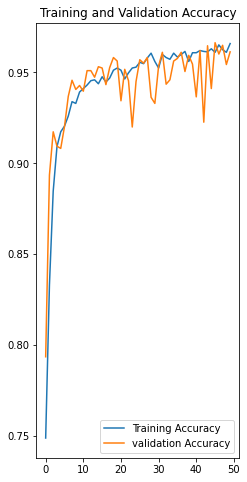

In [21]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(Epochs), acc, label='Training Accuracy')
plt.plot(range(Epochs), val_acc, label='validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
Actual label :  NORMAL
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Pred label :  NORMAL


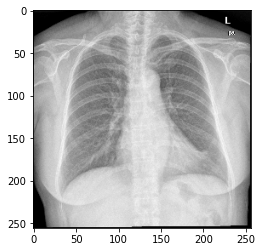

In [22]:
import numpy as np

for image_batch, label_batch in dataset.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("Actual label : ",class_names[first_label])
    
    
    batch_pred = model.predict(image_batch)
    print("Pred label : ",class_names[np.argmax(batch_pred[0])])
    

In [23]:
def pred(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

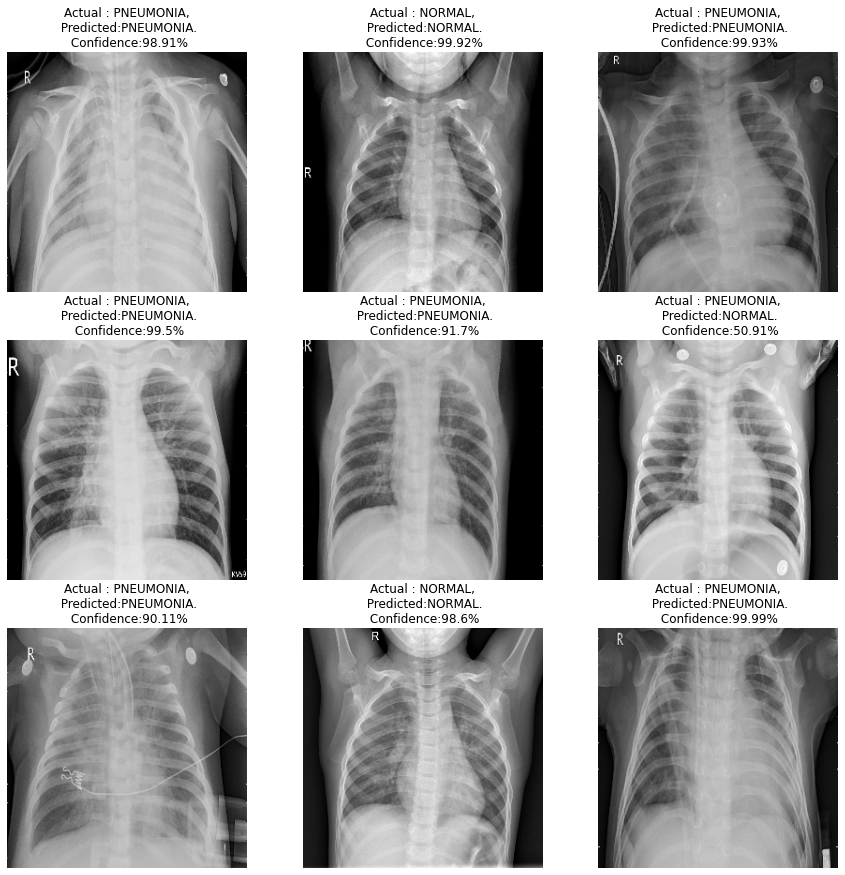

In [24]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = pred(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual : {actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")
        
        plt.axis("off")

In [25]:
# import os
# model_version=max([int(i) for i in os.listdir("C:/Users/MEGIC/Chest CV/models")+[0]])+1
# # model.save(f"../Models/{model_version}")
# model.save(f"C:/Users/MEGIC/Chest CV/models/{model_version}", save_format='h5')